## Dependencies

In [ ]:
# Dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O, data manipulation as in SQL
from sqlalchemy import create_engine # connecting to sql database
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph.
%matplotlib inline
from sklearn.linear_model import LogisticRegression # to apply the Logistic regression
from sklearn.model_selection import train_test_split # to split the data into two parts
# from sklearn.cross_validation import KFold # use for cross validation
from sklearn.model_selection import GridSearchCV# for tuning parameter
from sklearn.ensemble import RandomForestClassifier # for random forest classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm # for Support Vector Machine
from sklearn import metrics # for the check the error and accuracy of the model

In [ ]:
# Connect to SQL Database
rds_connection_string = "postgres:postgres@final-project-060521-001.cklzu8aj5kxi.us-east-2.rds.amazonaws.com:5432/breast_cancer"
engine = create_engine(f'postgresql://{rds_connection_string}')


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
# Read in data from sql
data = pd.read_sql('SELECT * FROM wisconsin_breast_cancer', con=engine)

## Data Exploration & Clean-Up

In [ ]:
# Preview data
data.head(2)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [ ]:
# Preview type of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

The data has 3 major categories with repeating sub-categories. As seen above, the 3 main categories are mean (mean of all cells), se (standard error of all cells), and worst (the worst cell). I am going to break the data up into these 3 categories in order to reference them in the machine learning analysis later.

In [ ]:
# Separate data into 3 parts according to their catergory
mean = list(data.columns[1:11])
se = list(data.columns[11:20])
worst = list(data.columns[21:31])
print(mean)
print("-----------------------------------")
print(se)
print("------------------------------------")
print(worst)

['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean']
-----------------------------------
['fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se']
------------------------------------
['fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst']


In [ ]:
# Map diagnosis objects to integer values
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})

In [ ]:
# Confirm change in values
data.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
5,843786,1,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
6,844359,1,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.01382,0.02254,0.01039,0.01369,0.002179,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
7,84458202,1,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.03029,0.02488,0.01448,0.01486,0.005412,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
8,844981,1,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,0.3063,1.0020,2.406,24.32,0.005731,0.03502,0.03553,0.01226,0.02143,0.003749,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720
9,84501001,1,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,0.2976,1.5990,2.039,23.94,0.007149,0.07217,0.07743,0.01432,0.01789,0.010080,15.09,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750


## Explore the Data

In [ ]:
# View stats for all data
data.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


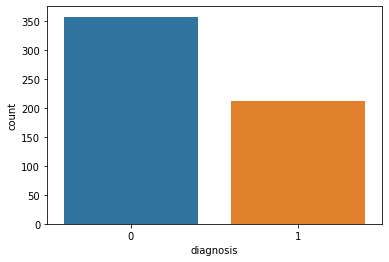

In [ ]:
# Plot the frequencies of cancer stages
sns.countplot(data['diagnosis'],label="Count")

from this graph we can see that there is larger number of bengin stage of cancer than malignant

## Data Analysis & Machine Learning

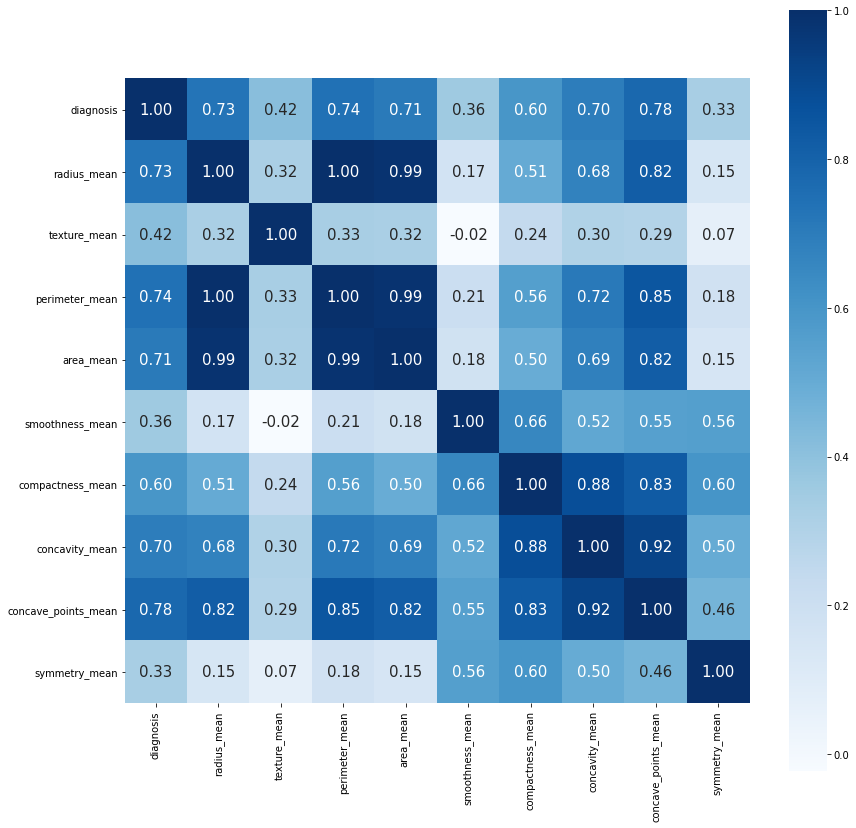

In [ ]:
# Creating a correlation graph to remove multi colinearity for the mean category

# Using .corr to find the corelation
corr = data[mean].corr() 
plt.figure(figsize=(14,14))
corr_graph = sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= mean, yticklabels= mean,
           cmap= 'Blues') 
# for more on the heatmap you can visit Link(http://seaborn.pydata.org/generated/seaborn.heatmap.html)

#### Observations

* the radius, perimeter and area are highly correlated as expected from their relation however, I will use one of these in my selected parameters
* compactness_mean, concavity_mean and concavepoint_mean are highly correlated so I will use compactness_mean from here
* the selected Parameters for use are perimeter_mean, texture_mean, compactness_mean, symmetry_mean, and smoothness_mean

In [ ]:
# Define the variables used for the prediction as determined in the above analysis
prediction_mean_subgroup = ['texture_mean','perimeter_mean','smoothness_mean','compactness_mean','symmetry_mean']

In [ ]:
# Split the data into train and test
train, test = train_test_split(data, test_size = 0.3)
# Check their dimension
print(train.shape)
print(test.shape)

(398, 32)
(171, 32)


In [ ]:
# Training data input
train_X = train[prediction_mean_subgroup] 
# Training data output
train_y = train.diagnosis
# Testing data input
test_X = test[prediction_mean_subgroup] 
# Testing data output
test_y = test.diagnosis 

In [ ]:
# Define a simple random forrest model
model=RandomForestClassifier(n_estimators=100)

In [ ]:
# Fit model to training data
model.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# Predict for the test data
prediction=model.predict(test_X)

In [ ]:
# Check the accuracy measurement between the predicted value and the test output values
accuracy = metrics.accuracy_score(prediction,test_y)
accuracy_percent = accuracy*100
print('Here the accuracy for the test is %.1f percent' % accuracy_percent)

Here the accuracy for the test is 91.8 percent


In [ ]:
# Trying SVM to compare accuracy
model = svm.SVC()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
accuracy = metrics.accuracy_score(prediction,test_y)
accuracy_percent = accuracy*100
print('Here the accuracy for the test is %.1f percent' % accuracy_percent)

Here the accuracy for the test is 90.1 percent


Now, I want to compare this sub-group of tumor attributes with the whole group to see which provides greater accuracy.

In [ ]:
# Redefine our prediction to take all features from the feature_mean
prediction_mean = mean

In [ ]:
# Update training variables
train_X= train[prediction_mean]
train_y= train.diagnosis
test_X = test[prediction_mean]
test_y = test.diagnosis

In [ ]:
model=RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(train_X,train_y)
prediction = model.predict(test_X)
accuracy = metrics.accuracy_score(prediction,test_y)
accuracy_percent = accuracy*100
print('Here the accuracy for the test is %.1f percent' % accuracy_percent)

Here the accuracy for the test is 100.0 percent


In [ ]:
# Trying SVM to compare accuracy
model = svm.SVC()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
accuracy = metrics.accuracy_score(prediction,test_y)
accuracy_percent = accuracy*100
print('Here the accuracy for the test is %.1f percent' % accuracy_percent)

Here the accuracy for the test is 91.8 percent


As seen above, the accuracy with the use of all attributes is better than just with the selected few. I will continue to use the whole sub-groups going forward.

Now, I am going to check if the "worse" category is in fact worse than the "mean" category.

In [ ]:
# Redefine our prediction to take all features from the feature_mean
prediction_worse = worst

In [ ]:
# Update training variables
train_X= train[prediction_worse]
train_y= train.diagnosis
test_X = test[prediction_worse]
test_y = test.diagnosis

In [ ]:
model=RandomForestClassifier(n_estimators=100)

In [ ]:
model.fit(train_X,train_y)
prediction = model.predict(test_X)
accuracy = metrics.accuracy_score(prediction,test_y)
accuracy_percent = accuracy*100
print('Here the accuracy for the test is %.1f percent' % accuracy_percent)

Here the accuracy for the test is 95.9 percent


In [ ]:
# Trying SVM to compare accuracy
model = svm.SVC()
model.fit(train_X,train_y)
prediction=model.predict(test_X)
accuracy = metrics.accuracy_score(prediction,test_y)
accuracy_percent = accuracy*100
print('Here the accuracy for the test is %.1f percent' % accuracy_percent)

Here the accuracy for the test is 94.2 percent


As expected, the "worse" category has worse accuracy when using the random forest, however, it is surprisingly more accurate when using the SVM model.

## Next Steps: Use the model to predict the outome from given data and check accuracy of model